In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

from keras import Model
from keras.layers import Input, Dense, Dropout, LSTM, SimpleRNN, GRU

%matplotlib inline

Using TensorFlow backend.


In [2]:
MIN_EVENT_TIME = 5
MAX_EVENT_TIME = 20
MIN_EVENT_POWER = 0.05
MAX_EVENT_POWER = 0.5

BASINS = [
    (0.02, 20),
    (0.02, 30),
    (0.01, 35),
    (0.03, 41),
    (0.02, 45),
    (0.01, 54),
    (0.02, 65),
    (0.01, 75),
]

def gen_precip(num_samples, num_events):  
    
    result = np.zeros(num_samples)
    
    for event_start in random.sample(range(num_samples - MAX_EVENT_TIME), num_events):
        event = np.zeros((num_samples,))
        event_time = random.randint(MIN_EVENT_TIME, MAX_EVENT_TIME)
        event_power = random.random() * (MAX_EVENT_POWER - MIN_EVENT_POWER) + MIN_EVENT_POWER
        event[event_start: event_start + event_time] = (np.cos(np.linspace(-np.pi, np.pi, num=event_time)) * 0.5 + 0.5) * event_power
        result += event
    
    return result

def gen_discharge(basins, precip, runoff):            
    all_precip = np.zeros(precip.shape)
    
    for basin in basins:
        lagged = np.roll(precip * basin[0], basin[1])
        lagged[:basin[1]] = 0
        all_precip += lagged
        
    discharge = np.zeros(precip.shape)
        
    for i in range(1, len(discharge)):
        discharge[i] = discharge[i - 1]  * (1 - runoff) + all_precip[i]
        
    return discharge, precip

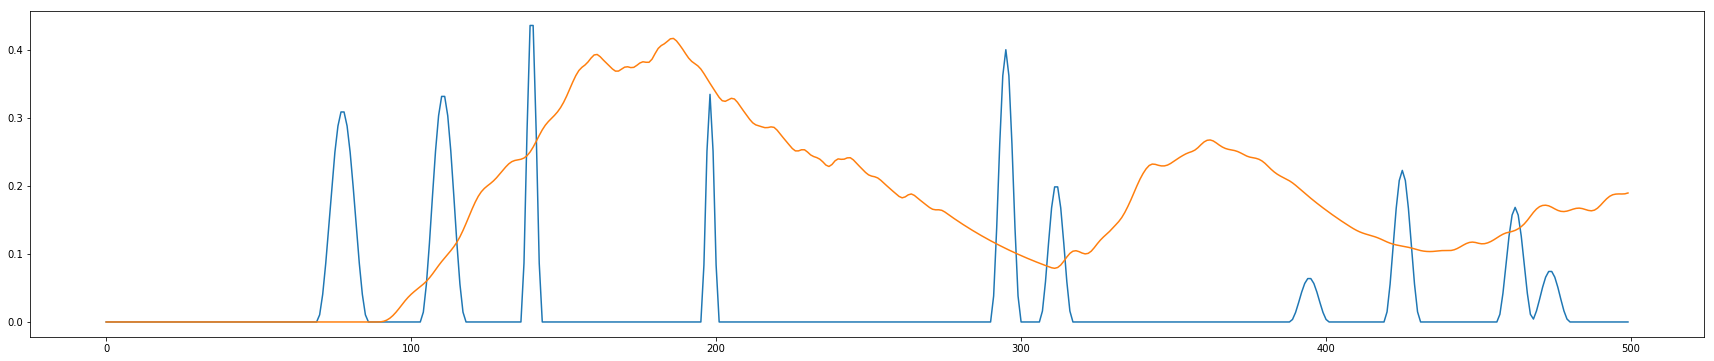

In [22]:
precip = gen_precip(500, 10)
discharge, _ = gen_discharge(BASINS, precip, 0.01)

plt.figure(figsize=(30,6))
plt.plot(precip)
plt.plot(discharge)
plt.show()

In [23]:
import random

NUM_SAMPLES = 2000
SEQ_LEN = 500

raw_train_Y, raw_train_X = zip(*[gen_discharge(BASINS, gen_precip(SEQ_LEN, 10), 0.01) for i in range(NUM_SAMPLES)])

## Feed-forward network

In [25]:
inputs = Input(shape=(SEQ_LEN,))
x = Dense(200, activation='tanh')(inputs)
x = Dense(200, activation='tanh')(x)
x = Dense(200, activation='tanh')(x)
outputs = Dense(SEQ_LEN, activation='linear')(x)

fnn_model = Model(inputs, outputs)
fnn_model.compile(optimizer='adam', loss='mse')
fnn_model.summary()

fnn_train_X = np.vstack(raw_train_X)
fnn_train_Y = np.vstack(raw_train_Y)

progress = fnn_model.fit(fnn_train_X, fnn_train_Y, validation_split=0.1, epochs=50)

W1024 13:23:39.647117 139785740855040 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1024 13:23:39.682542 139785740855040 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1024 13:23:39.687342 139785740855040 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1024 13:23:39.747797 139785740855040 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1024 13:23:39.899897 139785740855040 deprecation_wrappe

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               100200    
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_3 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_4 (Dense)              (None, 500)               100500    
Total params: 281,100
Trainable params: 281,100
Non-trainable params: 0
_________________________________________________________________


W1024 13:23:40.032677 139785740855040 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 1800 samples, validate on 200 samples
Epoch 1/50
1800/1800 [==============================] - 1s 283us/step - loss: 0.0144 - val_loss: 0.0026
Epoch 2/50
1800/1800 [==============================] - 0s 103us/step - loss: 0.0014 - val_loss: 7.8487e-04
Epoch 3/50
1800/1800 [==============================] - 0s 98us/step - loss: 6.0490e-04 - val_loss: 4.7304e-04
Epoch 4/50
1800/1800 [==============================] - 0s 108us/step - loss: 3.8865e-04 - val_loss: 3.3985e-04
Epoch 5/50
1800/1800 [==============================] - 0s 99us/step - loss: 2.9399e-04 - val_loss: 2.7545e-04
Epoch 6/50
1800/1800 [==============================] - 0s 97us/step - loss: 2.5459e-04 - val_loss: 2.8450e-04
Epoch 7/50
1800/1800 [==============================] - 0s 98us/step - loss: 2.4033e-04 - val_loss: 2.3146e-04
Epoch 8/50
1800/1800 [==============================] - 0s 102us/step - loss: 2.3214e-04 - val_loss: 2.3326e-04
Epoch 9/50
1800/1800 [==============================] - 0s 103us/step - l

In [50]:
TEST_SEQ_LEN = 500
test_output, test_input = gen_discharge(BASINS, gen_precip(TEST_SEQ_LEN, 10), 0.01)

In [28]:
prediction = fnn_model.predict(test_input.reshape(1, SEQ_LEN))[0]

In [ ]:
plt.figure(figsize=(30,6))
plt.plot(test_input)
plt.plot(prediction, 'green')
plt.plot(test_output, 'r--')
plt.show()

## Recurrent network

In [ ]:
inputs = Input(shape=(None, 1))
x = SimpleRNN(128, return_sequences=True)(inputs)
x = SimpleRNN(64, return_sequences=True)(x)
outputs = SimpleRNN(1, return_sequences=True, activation='linear')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')
model.summary()

train_X = np.vstack(raw_train_X).reshape((NUM_SAMPLES, SEQ_LEN, 1))
train_Y = np.vstack(raw_train_Y).reshape((NUM_SAMPLES, SEQ_LEN, 1))

In [34]:
inputs = Input(shape=(None, 1))
x = LSTM(128, return_sequences=True, recurrent_activation='sigmoid')(inputs)
outputs = Dense(1, activation='linear')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')
model.summary()

train_X = np.vstack(raw_train_X).reshape((NUM_SAMPLES, SEQ_LEN, 1))
train_Y = np.vstack(raw_train_Y).reshape((NUM_SAMPLES, SEQ_LEN, 1))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, 1)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 128)         66560     
_________________________________________________________________
dense_6 (Dense)              (None, None, 1)           129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [36]:
progress = model.fit(train_X, train_Y, validation_split=0.1, epochs=15)

Train on 1800 samples, validate on 200 samples
Epoch 1/15
1800/1800 [==============================] - 11s 6ms/step - loss: 0.0229 - val_loss: 0.0222
Epoch 2/15
1800/1800 [==============================] - 11s 6ms/step - loss: 0.0233 - val_loss: 0.0352
Epoch 3/15
1800/1800 [==============================] - 12s 6ms/step - loss: 0.0248 - val_loss: 0.0226
Epoch 4/15
1800/1800 [==============================] - 12s 6ms/step - loss: 0.0230 - val_loss: 0.0225
Epoch 5/15
1800/1800 [==============================] - 11s 6ms/step - loss: 0.0229 - val_loss: 0.0223
Epoch 6/15
1800/1800 [==============================] - 11s 6ms/step - loss: 0.0227 - val_loss: 0.0218
Epoch 7/15
1800/1800 [==============================] - 11s 6ms/step - loss: 0.0166 - val_loss: 0.0041
Epoch 8/15
1800/1800 [==============================] - 11s 6ms/step - loss: 0.0055 - val_loss: 0.0019
Epoch 9/15
1800/1800 [==============================] - 11s 6ms/step - loss: 0.0057 - val_loss: 0.0029
Epoch 10/15
1800/1800 [===

In [57]:
model.save_weights("rr_lstm.npy")

In [80]:
TEST_SEQ_LEN = 1500
test_output, test_input = gen_discharge(BASINS, gen_precip(TEST_SEQ_LEN, 10), 0.01)

In [81]:
prediction = model.predict(test_input.reshape((1, TEST_SEQ_LEN, 1)))[0]

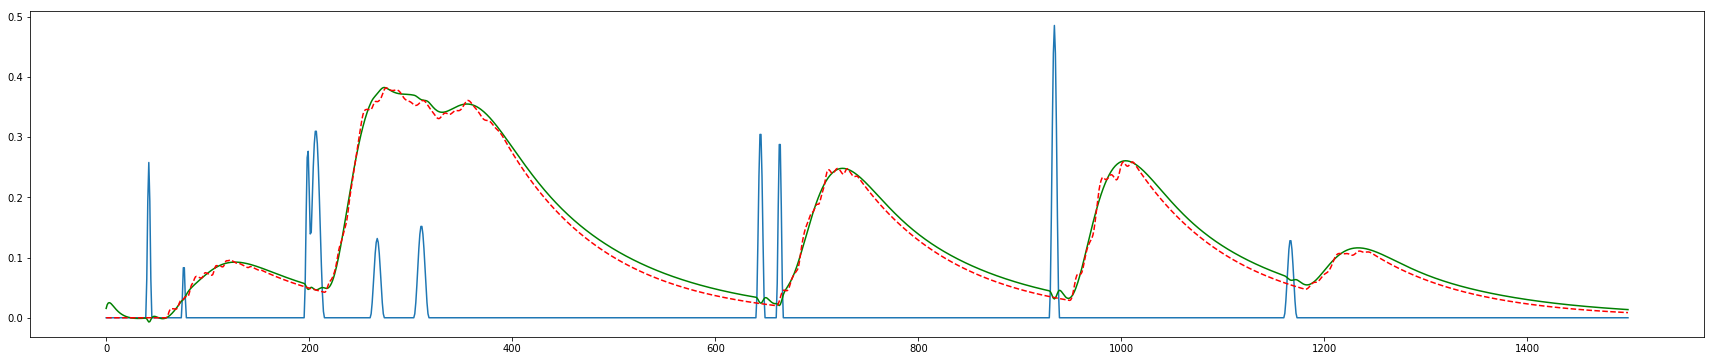

In [82]:
plt.figure(figsize=(30,6))
plt.plot(test_input)
plt.plot(prediction, 'green')
plt.plot(test_output, 'r--')
plt.show()

## Sliding window feed forward network
Feed-forward network can be used for longer inputs by "sliding" it over the input interval to gather enough context.

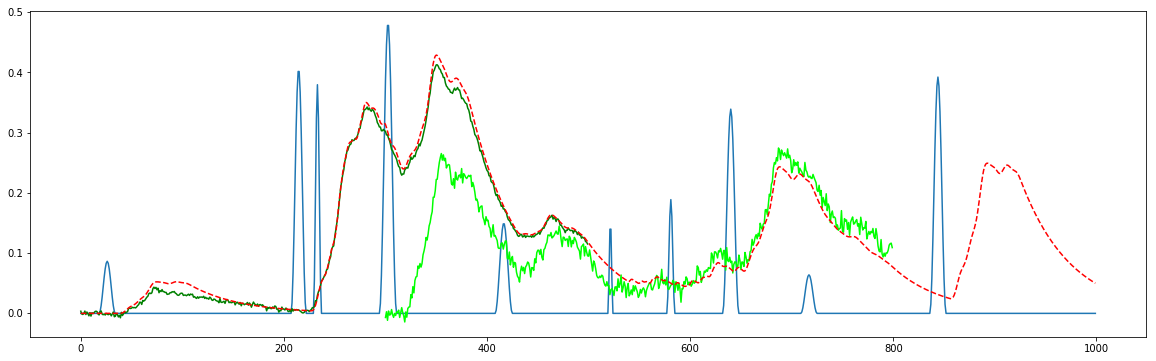

In [45]:
p1 = fnn_model.predict(test_input[:SEQ_LEN].reshape((1, SEQ_LEN)))[0]
p2 = fnn_model.predict(test_input[SEQ_LEN - 200: 2 * SEQ_LEN - 200].reshape((1, SEQ_LEN)))[0]

plt.figure(figsize=(20,6))
plt.plot(test_input[:1000])
plt.plot(range(SEQ_LEN - 200,  2 * SEQ_LEN - 200), p2, 'lime')
plt.plot(range(SEQ_LEN), p1, 'green')
plt.plot(test_output[:1000], 'r--')
plt.show()

## Continuous prediction with LSTM network
LSTM can be used for daily prediction inslead of prediction on the full input.

In [56]:
inputs = Input(batch_shape=(1, 1, 1))
x = LSTM(128, return_sequences=True, recurrent_activation='sigmoid', stateful=True)(inputs)
outputs = Dense(1, activation='linear')(x)
c_model = Model(inputs, outputs)
c_model.compile(optimizer='adam', loss='mse')
c_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (1, 1, 1)                 0         
_________________________________________________________________
lstm_5 (LSTM)                (1, 1, 128)               66560     
_________________________________________________________________
dense_9 (Dense)              (1, 1, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


We are using the **same LSTM model instance** as above! Only sequence length is different.

In [77]:
c_model.load_weights("rr_lstm.npy")

First, the model is filled with the context from history

In [59]:
c_model.reset_states()
HISTORY_LEN = 1000

c_prediction = []

for i in range(HISTORY_LEN):
    single_pred = c_model.predict(test_input[i].reshape(1, 1, 1))[0][0][0]
    c_prediction.append(single_pred)

Next, the model predicts output day by day

In [60]:
for i in range(500):
    daily_measure = test_input[HISTORY_LEN + i].reshape(1, 1, 1)
    single_pred = c_model.predict(daily_measure)[0][0][0]
    c_prediction.append(single_pred)

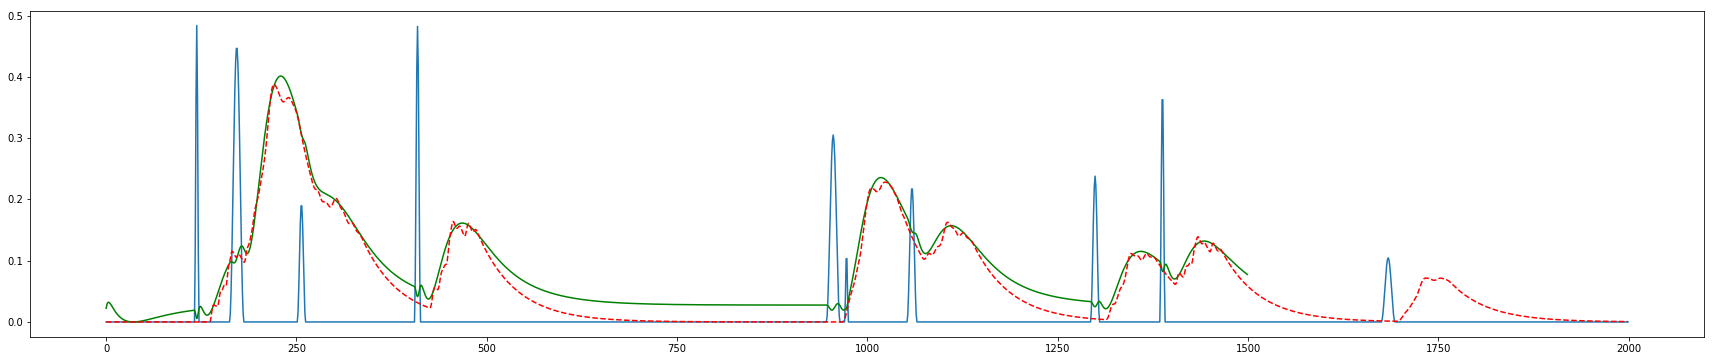

In [61]:
plt.figure(figsize=(30,6))
plt.plot(test_input)
plt.plot(c_prediction, 'green')
plt.plot(test_output, 'r--')
plt.show()

In [ ]:
#utility code to plot loss history

loss_history = np.array(progress.history['loss'])
val_loss_history = np.array(progress.history['val_loss'])
                            
plt.figure(figsize=(20,5))
plt.ylim(ymin=0, ymax=max(np.max(loss_history), np.max(val_loss_history)))
plt.plot(loss_history, 'r-')
plt.plot(val_loss_history, 'g-')
plt.show()